In [1]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/My Drive/Stock/LSTM/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Packages

In [2]:
from datetime import datetime
from datetime import timedelta
from datetime import date
from pylab import rc, rcParams
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model
from sklearn.metrics import mean_squared_error
import pandas_datareader as web
import csv
import math
import matplotlib
import numpy as np
import pandas as pd
import os

Using TensorFlow backend.


# Parameters

In [0]:
stock = 'acn' # stock
days = 5000   # number of samples
predict_var = 'adj_close'
test_size = 0.2
N=3           # using N value of x to get y 

lstm_units=128                 # lstm param
dropout_prob=0.2               # lstm param
optimizer='adam'               # lstm param
epochs=200                     # lstm param
batch_size=8                   # lstm param

pred_N = 3                     # prediction param

# Load Stock Data

In [0]:
# load stock history data from yahoo and save to csv file
fileName = stock.upper()
start = datetime.now() - timedelta(days=days)
end = datetime.now()
df = web.DataReader(stock, 'yahoo', start, end)
startDay = start.strftime("%Y-%m-%d")
df.to_csv(os.path.join(base_path, fileName+'.csv'))

In [5]:
# display dataframe
df = pd.read_csv(base_path+fileName+'.csv', sep = ",")
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]
df.sort_values(by='date', inplace=True, ascending=True)
df.head()

,date,high,low,open,close,volume,adj_close
0,2006-01-11,30.639999,30.059999,30.400000,30.639999,3241700.0,23.503866
1,2006-01-12,31.000000,30.540001,30.540001,30.590000,2459400.0,23.465506
2,2006-01-13,30.360001,30.070000,30.299999,30.209999,2486100.0,23.174007
3,2006-01-17,30.980000,29.500000,29.500000,30.840000,4440700.0,23.657282
4,2006-01-18,31.000000,30.410000,30.420000,30.990000,3454900.0,23.772346


In [6]:
df.tail()

,date,high,low,open,close,volume,adj_close
3441,2019-09-13,196.000000,193.960007,196.000000,194.619995,1592600.0,194.619995
3442,2019-09-16,195.220001,193.009995,193.369995,194.160004,1360000.0,194.160004
3443,2019-09-17,195.789993,193.360001,193.360001,194.949997,1457800.0,194.949997
3444,2019-09-18,194.589996,191.539993,194.179993,194.130005,1780500.0,194.130005
3445,2019-09-19,196.130005,194.220001,194.479996,194.669998,1567900.0,194.669998


Text(0, 0.5, 'USD')

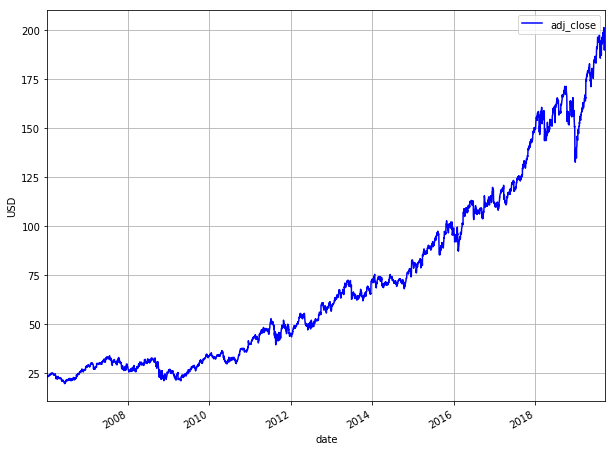

In [7]:
# plot history data
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = df.plot(x='date', y=predict_var, style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Modeling
This part is for modeling. If you have already train your model, you can skip to prediction.

## Split into train and test sets

In [8]:
num_test = int(test_size*len(df))
num_train = len(df) - num_test
print("Number of testing is: "+str(num_test))
print("Number of training is: "+str(num_train))

Number of testing is: 689
Number of training is: 2757


In [9]:
train = df[:num_train][['date', predict_var]]
test = df[num_train:][['date', predict_var]]
print("train.shape = " + str(train.shape))
print("test.shape = " + str(test.shape))

train.shape = (2757, 2)
test.shape = (689, 2)


In [10]:
# scaled train data
x_scaled, y_scaled = [], []
for i in range(N, len(train)):
    data_x_y = train[i-N:i+1]
    data_x_y = np.array(data_x_y[predict_var]).reshape(-1,1)
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(data_x_y)
    x_scaled.append(train_scaled[0:N])
    y_scaled.append(train_scaled[N])    
x_train_scaled = np.array(x_scaled)
y_train_scaled = np.array(y_scaled)

print("x_train_scaled.shape = " + str(x_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))

x_train_scaled.shape = (2754, 3, 1)
y_train_scaled.shape = (2754, 1)


In [11]:
# sclaed test data
x_test_scaled, y_test, mu_test, std_test = [], [], [], []
for i in range(num_train, len(df)):
    data_x_y = df[i-N:i+1]
    data_x_y = np.array(data_x_y[predict_var]).reshape(-1,1)
    mean = np.mean(data_x_y[0:N])
    std_ = np.std(data_x_y[0:N])
    x_test_scaled.append((data_x_y[0:N]-mean)/std_)
    y_test.append(data_x_y[N])
    mu_test.append(mean)
    std_test.append(std_)
        
x_test_scaled = np.array(x_test_scaled)
y_test = np.array(y_test)
print("x_test_scaled.shape = " + str(x_test_scaled.shape))
print("y_test_scaled.shape = " + str(y_test.shape))


x_test_scaled.shape = (689, 3, 1)
y_test_scaled.shape = (689, 1)


## Train Model

In [12]:
model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
model.add(Dropout(dropout_prob)) 
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob)) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=2)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/200
 - 5s - loss: 0.1156
Epoch 2/200
 - 4s - loss: 0.0074
Epoch 3/200
 - 4s - loss: 0.0073
Epoch 4/200
 - 4s - loss: 0.0070
Epoch 5/200
 - 4s - loss: 0.0067
Epoch 6/200
 - 4s - loss: 0.0073
Epoch 7/200
 - 4s - loss: 0.0066
Epoch 8/200
 - 4s - loss: 0.0072
Epoch 9/200
 - 4s - loss: 0.0069
Epoch 10/200
 - 4s - loss: 0.0060
Epoch 11/200
 - 4s - loss: 0.0068
Epoch 12/200
 - 4s - loss: 0.0069
Epoch 13/200
 - 4s - loss: 0.0066
Epoch 14/200
 - 4s - loss: 0.0064
Epoch 15/200
 - 4s - loss: 0.0059
Epoch 16/200
 - 4s - loss: 0.0062
Epoch 17/200
 - 4s - loss: 0.0066
Epoch 18/200
 - 4s - loss: 0.0067
Epoch 19/200
 - 4s - loss: 0.0065
Epoch 20/200
 - 4s - loss: 0.0057
Epoch 21/200
 - 4s - loss: 0.0072
Epoch 22/200
 - 4s - loss: 0.0059
Epoch 23/200
 - 4s - loss: 0.0055
Epoch 24/200

## Testing

In [13]:
est_scaled = model.predict(x_test_scaled)
est = (est_scaled * np.array(std_test).reshape(-1,1)) + np.array(mu_test).reshape(-1,1)
rmse = math.sqrt(mean_squared_error(y_test, est))
rmse

2.2116594602349156

In [14]:
result_df = pd.DataFrame({'date': df[num_train:]['date'],
                          'pred_y': est.reshape(-1),
                          'actual_y':y_test.reshape(-1)})
result_df.head(10)

,date,pred_y,actual_y
2757,2016-12-22,116.626904,112.483986
2758,2016-12-23,114.675915,112.187943
2759,2016-12-27,112.433974,112.254799
2760,2016-12-28,112.314510,111.357140
2761,2016-12-29,111.968727,111.739128
2762,2016-12-30,111.797209,111.853714
2763,2017-01-03,111.651970,111.213890
2764,2017-01-04,111.625533,111.481277
2765,2017-01-05,111.525999,109.810112
2766,2017-01-06,110.897051,111.061104


In [15]:
result_df.tail(10)

,date,pred_y,actual_y
3436,2019-09-06,197.664961,201.119995
3437,2019-09-09,199.453632,194.830002
3438,2019-09-10,198.688035,189.660004
3439,2019-09-11,195.527198,191.369995
3440,2019-09-12,192.039377,195.520004
3441,2019-09-13,192.200578,194.619995
3442,2019-09-16,193.846637,194.160004
3443,2019-09-17,194.802782,194.949997
3444,2019-09-18,194.579960,194.130005
3445,2019-09-19,194.425105,194.669998


Text(0, 0.5, 'USD')

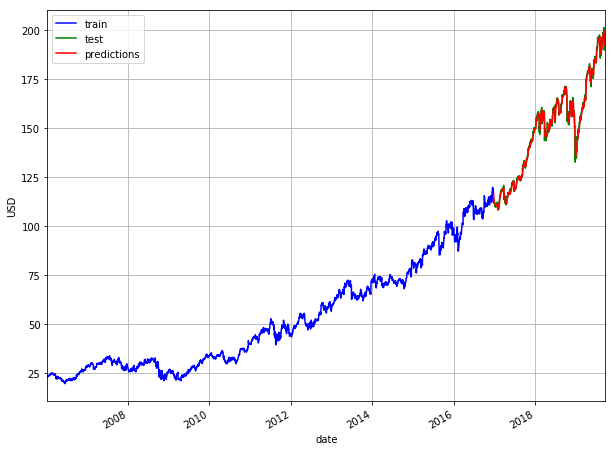

In [16]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'date': df[num_train:]['date']})

ax = train.plot(x='date', y=predict_var, style='b-', grid=True)
ax = test.plot(x='date', y=predict_var, style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

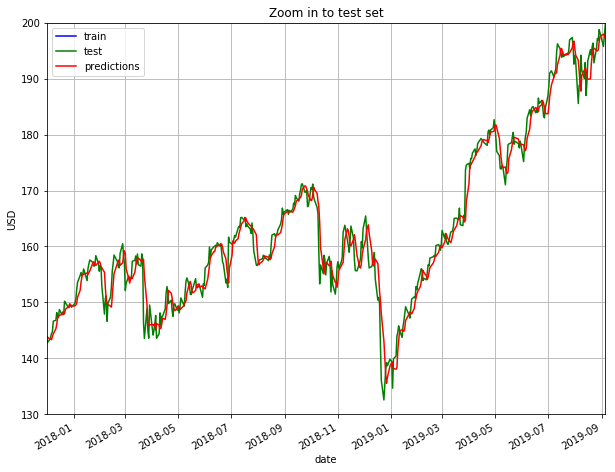

In [17]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y=predict_var, style='b-', grid=True)
ax = test.plot(x='date', y=predict_var, style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train',  'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 12, 1), date(2019, 9, 5)])
ax.set_ylim([130, 200])
ax.set_title("Zoom in to test set")

## Save Model

In [0]:
model.save_weights(base_path+"model/"+fileName+"_model.h5")

# Prediction

## Load Model

In [0]:
model.load_weights(base_path+"model/"+fileName+"_model.h5")

## Predict stock price

In [20]:
df_pred = df[predict_var]
prediction = []
for i in range(pred_N):
    df_pred = df_pred[-N:]
    pred = np.array(df_pred).reshape(-1,1)
    mean = np.mean(pred[0:N])
    std = np.std(pred[0:N])
    x_pred_scaled = []
    x_pred_scaled.append((pred[0:N]-mean)/std)
    x_pred_scaled = np.array(x_pred_scaled)
    est_scaled = model.predict(x_pred_scaled)
    est = est_scaled.item(0) * std + mean
    pred_row = pd.Series([est])
    df_pred = df_pred.append(pred_row , ignore_index=True)
    prediction.append(est)

print("Future "+str(pred_N)+" days prediction: ")
prediction
    

Future 3 days prediction: 


[194.59422583345557, 194.4662420996759, 194.58320692257624]